## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

Using data with border_reflect_101 and imgaug to add classes

Note we dont use aug on irregular metal

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [3]:
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [4]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [5]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [6]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [7]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [8]:
RETRAIN = True
RESIZE_IMAGES = True

In [9]:
MODEL_NAME='cv_reflect_101'
border='clipped'

In [10]:
NB_NUM='05_4'

In [11]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 5aa2b599, DATE: 20191029


In [41]:
DATE='20191028'
UID='d712faf5'

In [12]:
SUB_NUM='3'

In [13]:
img_size=256

In [14]:
train_images=data_dir/f'train/rotated/clipped/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{img_size}'

In [15]:
test_names = get_image_files(test_images)

In [16]:
assert len(test_names)==7325

In [17]:
df_all=pd.read_csv(data_dir/f'df_aug_{border}.csv')

In [18]:
df_all.tail()

,id,roof_material,verified,country,region
61228,7a3d40e2_imgaug_0_589,irregular_metal,True,colombia,borde_rural
61229,7a41538a_imgaug_1_555,irregular_metal,True,colombia,borde_rural
61230,7a28b708_imgaug_2_4114,irregular_metal,True,colombia,borde_soacha
61231,7a2f3042_imgaug_1_1290,incomplete,True,colombia,borde_rural
61232,7a2c65ce_imgaug_1_7114,irregular_metal,True,guatemala,mixco_1_and_ebenezer


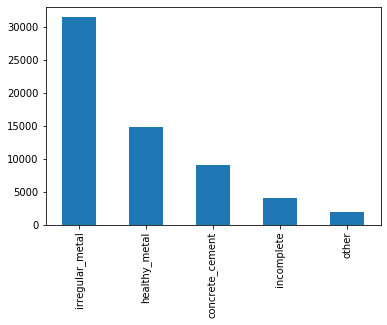

In [19]:
df_all['roof_material'].value_counts().plot(kind='bar')

In [20]:
df_img=df_all[df_all.id.str.contains('imgaug')]

In [21]:
df_img=df_img.loc[df_img['roof_material'] == 'irregular_metal']

In [22]:
aug_ids=df_img.index.tolist()

In [23]:
df_all_aug=df_all.drop(aug_ids)

In [24]:
len(df_all_aug)

35028

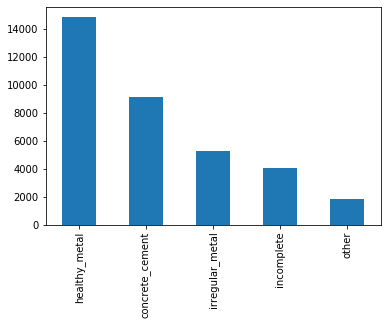

In [25]:
df_all_aug['roof_material'].value_counts().plot(kind='bar')

In [26]:
df_all=df_all_aug

In [27]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [28]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [29]:
assert len(df_test)==7325

In [30]:
df_all.loc[df_all['id'] == '7a204ec4']

,id,roof_material,verified,country,region
12960,7a204ec4,irregular_metal,True,guatemala,mixco_1_and_ebenezer


In [31]:
len(df_all)

35028

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [32]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [33]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [34]:
data = (src.transform(tfms, size=img_size)
        .databunch().normalize(imagenet_stats))

In [35]:
#to check what params object has
#dir(data)

In [36]:
data.label_list

LabelLists;

Train: LabelList (28023 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (7005 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,concrete_cement,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256

In [37]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

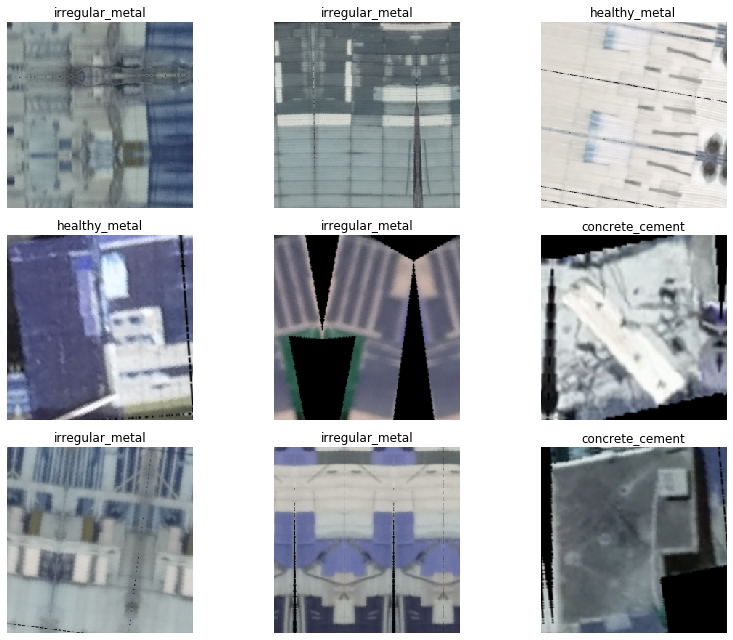

In [38]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [39]:
arch = models.resnet50
arch_name = 'rn50'

In [40]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16()

In [53]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### Train model

In [54]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


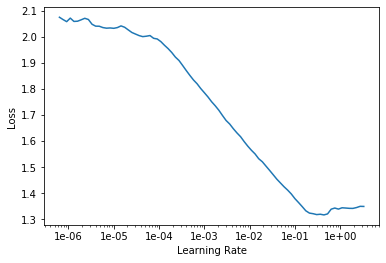

In [55]:
learn.recorder.plot()

Then we can fit the head of our network.

In [56]:
lr = 1e-2

In [57]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.614593,0.548855,0.200999,01:48
1,0.484758,0.481186,0.186438,01:47
2,0.430334,0.405901,0.155746,01:46
3,0.353053,0.383924,0.149893,01:48
4,0.342703,0.376731,0.146181,01:42


In [58]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [59]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (28023 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (7005 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,concrete_cement,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  

In [60]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 202),
 ('incomplete', 'irregular_metal', 186),
 ('healthy_metal', 'irregular_metal', 149),
 ('other', 'healthy_metal', 117),
 ('concrete_cement', 'healthy_metal', 97),
 ('incomplete', 'concrete_cement', 84),
 ('incomplete', 'healthy_metal', 40),
 ('healthy_metal', 'concrete_cement', 27),
 ('concrete_cement', 'incomplete', 26),
 ('concrete_cement', 'irregular_metal', 23),
 ('other', 'irregular_metal', 15),
 ('irregular_metal', 'incomplete', 12),
 ('healthy_metal', 'other', 11),
 ('irregular_metal', 'concrete_cement', 11),
 ('other', 'concrete_cement', 8),
 ('healthy_metal', 'incomplete', 6),
 ('concrete_cement', 'other', 5),
 ('incomplete', 'other', 2),
 ('irregular_metal', 'other', 2)]

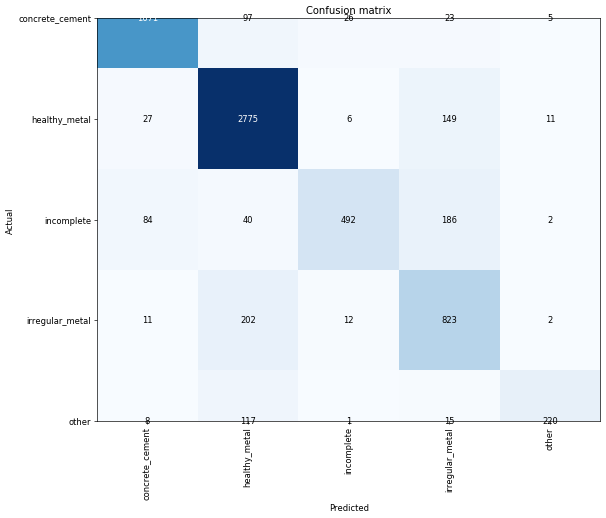

In [61]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [62]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


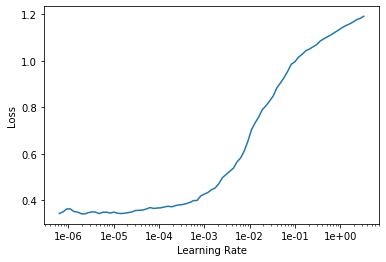

In [63]:
learn.lr_find()
learn.recorder.plot()

In [64]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.341818,0.343986,0.132191,01:51
1,0.316806,0.363378,0.139615,01:53
2,0.272709,0.294651,0.109065,01:52
3,0.222047,0.262236,0.099643,01:52
4,0.185744,0.265510,0.098929,01:52


In [65]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [66]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (28023 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (7005 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,concrete_cement,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  

In [67]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.194836,0.267812,0.098501,01:53
1,0.218707,0.276688,0.103640,01:53
2,0.191238,0.253865,0.094504,01:52
3,0.138990,0.234255,0.084226,01:53
4,0.111736,0.234004,0.084511,01:52


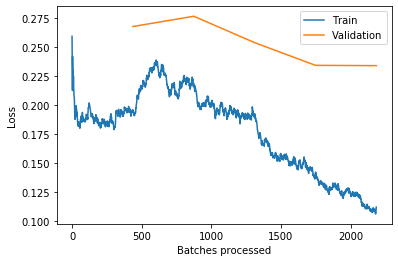

In [68]:
learn.recorder.plot_losses()

In [69]:
learn.save(f'stage-2_1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [ ]:
#reload

In [42]:
learn.load(f'stage-2_1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (28023 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (7005 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,concrete_cement,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  

### export as fp32

In [43]:
learn = learn.to_fp32()

In [44]:
learn.export(f'stage-2_1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

In [45]:
learn.export()

### inference

In [46]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [47]:
len(test_dataset)

15325

In [48]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', test=test_dataset)

In [49]:
#learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [50]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [51]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [52]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [53]:
len(learn.dl(DatasetType.Test))

240

Get number of items in the Valid dataset (in DeviceDataLoader)

In [54]:
#assert len(learn.dl(DatasetType.Test).dl)==7325

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [78]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [79]:
labels = np.argmax(preds, 1)

In [80]:
len(preds)

15325

In [81]:
preds[0].tolist()

[0.00171152304392308,
 0.995473325252533,
 0.00031444497290067375,
 0.002419964410364628,
 8.075153164099902e-05]

In [82]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [83]:
len(labels)

15325

In [84]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [85]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [86]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [87]:
test_predictions[0]

'healthy_metal'

In [88]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [89]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/clipped/256/7a4d9168.tif'),
       PosixPath('data/test/rotated/clipped/256/7a4ae922.tif'),
       PosixPath('data/test/rotated/clipped/256/7a48ca98.tif'),
       PosixPath('data/test/rotated/clipped/256/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a468774.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4b7946.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4e81f4.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a501f50.tif')], dtype=object)

In [90]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [91]:
preds_list[0]

[0.00171152304392308,
 0.995473325252533,
 0.00031444497290067375,
 0.002419964410364628,
 8.075153164099902e-05]

In [92]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [93]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [94]:
df.head()

,id,pred
0,7a4d9168,"[0.00171152304392308, 0.995473325252533, 0.000..."
1,7a4ae922,"[0.0044540162198245525, 0.9758846759796143, 0...."
2,7a48ca98,"[0.0002540354325901717, 0.022103263065218925, ..."
3,7a49c614,"[0.0006142950151115656, 0.8731414079666138, 0...."
4,7a4dd4f2,"[0.0013876042794436216, 0.6640383005142212, 0...."


In [95]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [96]:
pred_df.insert(loc=0, column='id', value=ids)

In [97]:
pred_df.columns = cols

In [98]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.001712,0.995473,0.000314,0.002420,0.000081
1,7a4ae922,0.004454,0.975885,0.000211,0.018474,0.000976
2,7a48ca98,0.000254,0.022103,0.047751,0.929363,0.000529
3,7a49c614,0.000614,0.873141,0.001389,0.123784,0.001072
4,7a4dd4f2,0.001388,0.664038,0.004835,0.325986,0.003753


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [99]:
#pred_df = pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

In [100]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.001712,0.995473,0.000314,0.002420,0.000081
1,7a4ae922,0.004454,0.975885,0.000211,0.018474,0.000976
2,7a48ca98,0.000254,0.022103,0.047751,0.929363,0.000529
3,7a49c614,0.000614,0.873141,0.001389,0.123784,0.001072
4,7a4dd4f2,0.001388,0.664038,0.004835,0.325986,0.003753


In [101]:
pred_ids=pred_df['id'].values.tolist()

In [102]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [103]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [104]:
baseline_ids=df_baseline['id'].values.tolist()

In [105]:
baseline_ids

['7a4d630a',
 '7a4bbbd6',
 '7a4ac744',
 '7a4881fa',
 '7a4aa4a8',
 '7a514434',
 '7a485f72',
 '7a4b8d32',
 '7a47eb3c',
 '7a4be3ae',
 '7a46a330',
 '7a481620',
 '7a49c678',
 '7a4ea044',
 '7a47aa1e',
 '7a51aa1e',
 '7a498be0',
 '7a4a2848',
 '7a4c4cd6',
 '7a465038',
 '7a4e94aa',
 '7a49f62a',
 '7a45b6f0',
 '7a50bb90',
 '7a4d38e4',
 '7a48a3a6',
 '7a4ebe9e',
 '7a48352e',
 '7a4bfaec',
 '7a51e060',
 '7a4c0f5a',
 '7a4b9976',
 '7a4b27d4',
 '7a51c698',
 '7a474bb4',
 '7a480054',
 '7a4a4044',
 '7a4c35ca',
 '7a4d3fd8',
 '7a4c1a68',
 '7a4eb1c4',
 '7a4a51ce',
 '7a4a14fc',
 '7a5015d2',
 '7a4ba95c',
 '7a5101ae',
 '7a4d0a22',
 '7a5134ee',
 '7a4a85c2',
 '7a514b14',
 '7a4d0a90',
 '7a485fd6',
 '7a4f668c',
 '7a44e752',
 '7a5162d4',
 '7a465894',
 '7a4c9a10',
 '7a485810',
 '7a4a9788',
 '7a503198',
 '7a4e206a',
 '7a4c15ea',
 '7a4f8536',
 '7a513df4',
 '7a4d7624',
 '7a4c9e8e',
 '7a4b2554',
 '7a502b12',
 '7a4c32e6',
 '7a4a8a2c',
 '7a467b76',
 '7a51b554',
 '7a4622e8',
 '7a4a599e',
 '7a4d17c4',
 '7a4fb740',
 '7a4ceed4',

In [106]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [107]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [108]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.001712,0.995473,0.000314,0.002420,0.000081,7a4d9168
1,7a4ae922,0.004454,0.975885,0.000211,0.018474,0.000976,7a4ae922
2,7a48ca98,0.000254,0.022103,0.047751,0.929363,0.000529,7a48ca98
3,7a49c614,0.000614,0.873141,0.001389,0.123784,0.001072,7a49c614
4,7a4dd4f2,0.001388,0.664038,0.004835,0.325986,0.003753,7a4dd4f2


In [109]:
pred_df=pred_df.sort_values('id_cat')

In [110]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
8041,7a4d630a,0.000031,0.998163,0.000248,0.001486,0.000073,7a4d630a
716,7a4d630a,0.000031,0.998163,0.000248,0.001486,0.000073,7a4d630a
764,7a4bbbd6,0.000303,0.992214,0.000187,0.007011,0.000285,7a4bbbd6
8089,7a4bbbd6,0.000303,0.992214,0.000187,0.007011,0.000285,7a4bbbd6
1841,7a4ac744,0.002992,0.566508,0.009126,0.419131,0.002244,7a4ac744


In [111]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [113]:
len(pred_df)

15325

In [123]:
pred_df = pred_df.drop_duplicates(subset=['id'])

In [124]:
len(pred_df)

7325

In [125]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [ ]:
### Submission 3
0.5557 

### Plot test predictions

In [126]:
pred_df.drop(columns=['id'],inplace=True)

In [127]:
classes=pred_df.idxmax(axis=1)

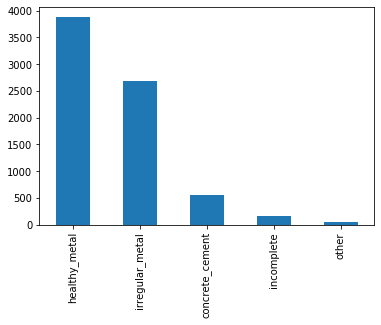

In [128]:
pd.value_counts(classes).plot(kind="bar")

Too many 'irregular metal'